In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nirmalsankalana/rice-leaf-disease-image")

print("Path to dataset files:", path)

100%|██████████| 195M/195M [00:00<00:00, 215MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nirmalsankalana/rice-leaf-disease-image/versions/1


In [14]:
import os

# Store the full path in a variable
dataset_path = '/root/.cache/kagglehub/datasets/nirmalsankalana/rice-leaf-disease-image/versions/1'

In [15]:
# List the subdirectories (which are the class names)
class_folders = os.listdir(dataset_path)
print("Class folders found:", class_folders)

# Peek inside the first class folder to see the image files
first_class_path = os.path.join(dataset_path, class_folders[0])
image_files = os.listdir(first_class_path)[:5] # Show first 5 files
print(f"\nSample image files in '{class_folders[0]}':", image_files)

Class folders found: ['Blast', 'Brownspot', 'Bacterialblight', 'Tungro']

Sample image files in 'Blast': ['BLAST9_062.jpg', 'BLAST4_131.jpg', 'BLAST4_062.jpg', 'BLAST6_093.jpg', 'BLAST1_084.jpg']


In [16]:
import tensorflow as tf

# Define parameters for loading the images
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load the entire dataset
# The function understands that each subfolder is a different class
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("\n✅ Dataset loaded successfully for training.")

Found 5932 files belonging to 4 classes.

✅ Dataset loaded successfully for training.


In [20]:
import tensorflow as tf
import kagglehub
import os

# Download the dataset and get the path
path = kagglehub.dataset_download("nirmalsankalana/rice-leaf-disease-image")

# THE FIX IS HERE: Use the main path directly
dataset_path = path

# Let's verify the contents of this path to be sure
print("Contents of the dataset directory:")
print(os.listdir(dataset_path))

# Define parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load the data and create a validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Get the class names
class_names = train_ds.class_names
print("\nClass Names:", class_names)

# Split the validation set to create a test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

print(f'\nNumber of training batches: {tf.data.experimental.cardinality(train_ds)}')
print(f'Number of validation batches: {tf.data.experimental.cardinality(val_ds)}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_ds)}')

# Configure for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Using Colab cache for faster access to the 'rice-leaf-disease-image' dataset.
Contents of the dataset directory:
['Tungro', 'Bacterialblight', 'Blast', 'Brownspot']
Found 5932 files belonging to 4 classes.
Using 4746 files for training.
Found 5932 files belonging to 4 classes.
Using 1186 files for validation.

Class Names: ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

Number of training batches: 149
Number of validation batches: 19
Number of test batches: 19


In [21]:
# Create a data augmentation layer to prevent overfitting
# This randomly flips and rotates images during training to make the model more robust
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Load the pre-trained MobileNetV2 model
# `include_top=False` means we don't include its original final classification layer
# `weights='imagenet'` specifies that we want the version trained on the ImageNet dataset
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the convolutional base to prevent its weights from being updated during training
base_model.trainable = False

# Create the full model by adding our new layers on top of the base
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs) # Apply augmentation
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # Preprocess input for MobileNetV2
x = base_model(x, training=False) # Run the base model in inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Pool the features down to a manageable size
x = tf.keras.layers.Dropout(0.2)(x) # Add dropout for regularization
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x) # Final classification layer

model = tf.keras.Model(inputs, outputs)

# Print a summary of the model's architecture
print("Model built successfully.")
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model built successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Model compiled successfully and is ready for training.")

Model compiled successfully and is ready for training.


In [23]:
# Set the number of epochs to train for
EPOCHS = 10

# Train the model by calling the .fit() method
# We store the results in a 'history' object to analyze them later
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

print("\n✅ Model training complete.")

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6654 - loss: 0.7980 - val_accuracy: 0.9031 - val_loss: 0.2412
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9113 - loss: 0.2463 - val_accuracy: 0.9550 - val_loss: 0.1464
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9473 - loss: 0.1600 - val_accuracy: 0.9377 - val_loss: 0.1513
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9502 - loss: 0.1404 - val_accuracy: 0.9550 - val_loss: 0.1230
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9622 - loss: 0.1244 - val_accuracy: 0.9585 - val_loss: 0.1080
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.9706 - loss: 0.1037 - val_accuracy: 0.9602 - val_loss: 0.1033
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9706 - loss: 0.0917 - val_accuracy: 0.9654 - val_loss: 0.0886
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9756 - loss: 0.0824 - val_accu

In [24]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)

# Print the final accuracy in a formatted way
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 798ms/step - accuracy: 0.9559 - loss: 0.1016

Test Accuracy: 96.55%


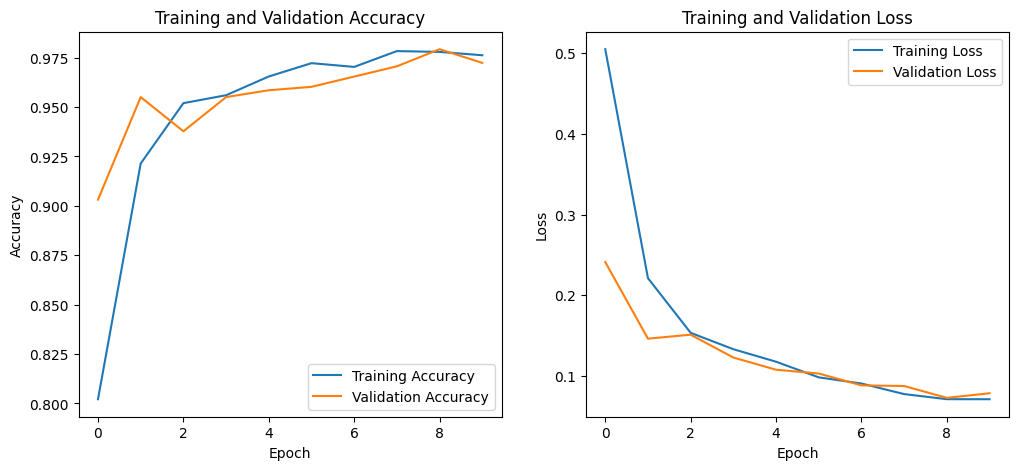

In [25]:
import matplotlib.pyplot as plt

# Retrieve the accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs the model was trained for
epochs_range = range(len(acc))

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [27]:
# Define a path to your Google Drive
save_path = '/content/drive/MyDrive/rice_leaf_disease_classifier.keras'

# Save the model to that path
model.save(save_path)

print(f"Model saved permanently to your Google Drive at: {save_path}")

Model saved permanently to your Google Drive at: /content/drive/MyDrive/rice_leaf_disease_classifier.keras
